In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [81]:
def extract_answer(text):
    pattern = r"(True|False|Don't know)"
    matches = re.findall(pattern, text)
    return matches

def extract_mcq_answer(text):
    try:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip().split('"')[1].strip()
    except:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip()
    return text_processed

def correct_paranthesis_split(text):
    try:
        text_processed = text.split('"answer":')[-1].split("\n")[1].split(":")[-1].split('"')[1].strip()
        return text_processed
    except:
        return text
    
def binary_process(prompt_response_df, rag_response_df):
    prompt_response_df.loc[:, "answer_count"] = prompt_response_df.extracted_answer.apply(lambda x:len(x))
    prompt_response_df_multiple_answers = prompt_response_df[prompt_response_df.answer_count > 1]
    prompt_response_df_single_answer = prompt_response_df.drop(prompt_response_df_multiple_answers.index)
    prompt_response_df_single_answer.drop("answer_count", axis=1, inplace=True)
    prompt_response_df_multiple_answers_ = []
    for index, row in prompt_response_df_multiple_answers.iterrows():
        if row["extracted_answer"][0] == row["extracted_answer"][1]:
            prompt_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], row["extracted_answer"][0]))
        else:
            prompt_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], None))
    prompt_response_df_multiple_answers_ = pd.DataFrame(prompt_response_df_multiple_answers_, columns=["question", "label", "llm_answer", "extracted_answer"])
    prompt_response_df_final = pd.concat([prompt_response_df_single_answer, prompt_response_df_multiple_answers_], ignore_index=True)
    prompt_response_df_final = prompt_response_df_final.explode("extracted_answer")

    rag_response_df.loc[:, "answer_count"] = rag_response_df.extracted_answer.apply(lambda x:len(x))
    rag_response_df_multiple_answers = rag_response_df[rag_response_df.answer_count > 1]
    rag_response_df_single_answer = rag_response_df.drop(rag_response_df_multiple_answers.index)
    rag_response_df_single_answer.drop("answer_count", axis=1, inplace=True)
    rag_response_df_multiple_answers_ = []
    for index, row in rag_response_df_multiple_answers.iterrows():
        if row["extracted_answer"][0] == row["extracted_answer"][1]:
            rag_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], row["extracted_answer"][0]))
        else:
            rag_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], None))
    rag_response_df_multiple_answers_ = pd.DataFrame(rag_response_df_multiple_answers_, columns=["question", "label", "llm_answer", "extracted_answer"])
    rag_response_df_final = pd.concat([rag_response_df_single_answer, rag_response_df_multiple_answers_], ignore_index=True)
    rag_response_df_final = rag_response_df_final.explode("extracted_answer")
    prompt_incorrect_answers_because_of_na = prompt_response_df_final[prompt_response_df_final.extracted_answer.isna()]
    rag_incorrect_answers_because_of_na = rag_response_df_final[rag_response_df_final.extracted_answer.isna()]

    row_index_to_drop = list(prompt_incorrect_answers_because_of_na.index.values) + list(rag_incorrect_answers_because_of_na.index.values)

    prompt_response_df_final.drop(row_index_to_drop, inplace=True)
    rag_response_df_final.drop(row_index_to_drop, inplace=True)

    prompt_response_df_final = prompt_response_df_final.reset_index()
    rag_response_df_final = rag_response_df_final.reset_index()
    response_transform = {
        "True" : True,
        "False" : False
    }
    prompt_response_df_final.extracted_answer = prompt_response_df_final.extracted_answer.apply(lambda x:response_transform[x])
    rag_response_df_final.extracted_answer = rag_response_df_final.extracted_answer.apply(lambda x:response_transform[x])
    return prompt_response_df_final, rag_response_df_final


def binary_evaluate(df):
    correct = df[df.label == df.extracted_answer]
    incorrect = df[df.label != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac


def binary_bootstrap(prompt_response_df_final, rag_response_df_final):
    niter = 1000
    nsample = 150
    prompt_correct_frac_list = []
    rag_correct_frac_list = []
    for i in tqdm(range(niter)):
        prompt_response_df_final_sample = prompt_response_df_final.sample(n=nsample, random_state=i)
        prompt_correct_frac, prompt_incorrect_frac = binary_evaluate(prompt_response_df_final_sample)

        rag_response_df_final_sample = rag_response_df_final.iloc[prompt_response_df_final_sample.index]
        rag_correct_frac, rag_incorrect_frac = binary_evaluate(rag_response_df_final_sample)

        prompt_correct_frac_list.append(prompt_correct_frac)
        rag_correct_frac_list.append(rag_correct_frac)
    return prompt_correct_frac_list, rag_correct_frac_list

def process_mcq(prompt_response_df, rag_response_df):
    prompt_response_df_paranthesis_split = prompt_response_df[prompt_response_df.extracted_answer=="{"]
    if prompt_response_df_paranthesis_split.shape[0] > 0:
        prompt_response_df_paranthesis_split.loc[:, "extracted_answer"] = prompt_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
        prompt_response_df_wo_paranthesis_split = prompt_response_df[prompt_response_df.extracted_answer != "{"]
        prompt_response_df = pd.concat([prompt_response_df_wo_paranthesis_split, prompt_response_df_paranthesis_split])

    rag_response_df_paranthesis_split = rag_response_df[rag_response_df.extracted_answer=="{"]
    if rag_response_df_paranthesis_split.shape[0] > 0:
        rag_response_df_paranthesis_split.loc[:, "extracted_answer"] = rag_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
        rag_response_df_wo_paranthesis_split = rag_response_df[rag_response_df.extracted_answer != "{"]
        rag_response_df = pd.concat([rag_response_df_wo_paranthesis_split, rag_response_df_paranthesis_split])
    return prompt_response_df, rag_response_df

def mcq_evaluate(df):
    correct = df[df.correct_answer == df.extracted_answer]
    incorrect = df[df.correct_answer != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac

def mcq_bootstrap(prompt_response_df, rag_response_df):
    niter = 1000
    nsample = 150
    prompt_correct_frac_list = []
    rag_correct_frac_list = []
    for i in tqdm(range(niter)):
        prompt_response_df_sample = prompt_response_df.sample(n=nsample, random_state=i)
        prompt_correct_frac, prompt_incorrect_frac = mcq_evaluate(prompt_response_df_sample)

        rag_response_df_sample = rag_response_df.iloc[prompt_response_df_sample.index]
        rag_correct_frac, rag_incorrect_frac = mcq_evaluate(rag_response_df_sample)

        prompt_correct_frac_list.append(prompt_correct_frac)
        rag_correct_frac_list.append(rag_correct_frac)
    return prompt_correct_frac_list, rag_correct_frac_list



def plot_hist_binary(prompt_correct_frac_list, rag_correct_frac_list, figure_folder_name=False, fig_name_prefix=False):
    # Create a figure and axis
    fig = plt.figure(figsize=(5, 3))
    ax = plt.gca()

    # Plot KDEs with the specified styling
    sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
    sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)

    # Set the outline color to black
    for artist in ax.lines:
        artist.set_edgecolor("black")

    # Add labels and legend
    plt.xlabel("Accuracy")
    plt.ylabel("Density")
    plt.legend(loc="upper left")
    plt.xlim(0.75,1)

    ax.axvline(np.mean(prompt_correct_frac_list), color='black', linestyle='--', lw=2)
    ax.axvline(np.mean(rag_correct_frac_list), color='black', linestyle='--', lw=2)

    sns.despine(top=True, right=True)


    # Show the plot
    plt.show()
    if figure_folder_name:
        fig_filename = "../../../data/analysis_results/figures/{}/{}_one_hop_true_false_binary_performance_with_mean_performance_line.svg".format(figure_folder_name, fig_name_prefix)
        fig.savefig(fig_filename, format='svg', bbox_inches='tight')


        
def plot_hist_mcq(prompt_correct_frac_list, rag_correct_frac_list, figure_folder_name=False, fig_name_prefix=False):
    # Create a figure and axis
    fig = plt.figure(figsize=(5, 3))
    ax = plt.gca()

    # Plot KDEs with the specified styling
    sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
    sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)

    # Set the outline color to black
    for artist in ax.lines:
        artist.set_edgecolor("black")

    # Add labels and legend
    plt.xlabel("Accuracy")
    plt.ylabel("Density")
    # plt.legend(bbox_to_anchor=(1.01, 0.9))
    plt.legend(bbox_to_anchor=(0.55, 0.9))
    plt.xlim(0.1,0.9)
    # plt.legend(loc='upper left')

    ax.axvline(np.mean(prompt_correct_frac_list), color='black', linestyle='--', lw=2)
    ax.axvline(np.mean(rag_correct_frac_list), color='black', linestyle='--', lw=2)

    sns.despine(top=True, right=True)

    # Show the plot
    plt.show()
    if figure_folder_name:
        fig_filename = "../../../data/analysis_results/figures/{}/{}_two_hop_MONARCH_ROBOKOP_combined_mcq_llm_performance_with_mean.svg".format(figure_folder_name, fig_name_prefix)
        fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [82]:
GPT_35_PROMPT_BINARY_RESPONSE_PATH = "../../../data/analysis_results/gpt_35_turbo_prompt_based_true_false_binary_response.csv"
GPT_35_RAG_BINARY_RESPONSE_PATH = "../../../data/analysis_results/gpt_35_turbo_PubMedBert_and_entity_recognition_based_node_retrieval_rag_based_true_false_binary_response.csv"
GPT_4_PROMPT_BINARY_RESPONSE_PATH = "../../../data/analysis_results/gpt_4_prompt_based_true_false_binary_response.csv"
GPT_4_RAG_BINARY_RESPONSE_PATH = "../../../data/analysis_results/gpt_4_PubMedBert_and_entity_recognition_based_node_retrieval_rag_based_true_false_binary_response.csv"

GPT_35_PROMPT_MCQ_RESPONSE_PATH = "../../../data/analysis_results/gpt_35_turbo_prompt_based_two_hop_mcq_from_monarch_and_robokop_response.csv"
GPT_35_RAG_MCQ_RESPONSE_PATH = "../../../data/analysis_results/gpt_35_turbo_PubMedBert_entity_recognition_based_node_retrieval_rag_based_two_hop_mcq_from_monarch_and_robokop_response.csv"
GPT_4_PROMPT_MCQ_RESPONSE_PATH = "../../../data/analysis_results/gpt_4_prompt_based_two_hop_mcq_from_monarch_and_robokop_response.csv"
GPT_4_RAG_MCQ_RESPONSE_PATH = "../../../data/analysis_results/gpt_4_PubMedBert_entity_recognition_based_node_retrieval_rag_based_two_hop_mcq_from_monarch_and_robokop_response.csv"



In [83]:
gpt_35_prompt_binary_response_df = pd.read_csv(GPT_35_PROMPT_BINARY_RESPONSE_PATH)
gpt_35_rag_binary_response_df = pd.read_csv(GPT_35_RAG_BINARY_RESPONSE_PATH)
gpt_35_prompt_binary_response_df.loc[:, 'extracted_answer'] = gpt_35_prompt_binary_response_df['llm_answer'].apply(extract_answer)
gpt_35_rag_binary_response_df.loc[:, 'extracted_answer'] = gpt_35_rag_binary_response_df['llm_answer'].apply(extract_answer)

gpt_4_prompt_binary_response_df = pd.read_csv(GPT_4_PROMPT_BINARY_RESPONSE_PATH)
gpt_4_rag_binary_response_df = pd.read_csv(GPT_4_RAG_BINARY_RESPONSE_PATH)
gpt_4_prompt_binary_response_df.loc[:, 'extracted_answer'] = gpt_4_prompt_binary_response_df['llm_answer'].apply(extract_answer)
gpt_4_rag_binary_response_df.loc[:, 'extracted_answer'] = gpt_4_rag_binary_response_df['llm_answer'].apply(extract_answer)

gpt_35_prompt_binary_response_df_final, gpt_35_rag_binary_response_df_final = binary_process(gpt_35_prompt_binary_response_df, gpt_35_rag_binary_response_df)
gpt_4_prompt_binary_response_df_final, gpt_4_rag_binary_response_df_final = binary_process(gpt_4_prompt_binary_response_df, gpt_4_rag_binary_response_df)

gpt_35_prompt_correct_frac_list_binary, gpt_35_rag_correct_frac_list_binary = binary_bootstrap(gpt_35_prompt_binary_response_df_final, gpt_35_rag_binary_response_df_final)
gpt_4_prompt_correct_frac_list_binary, gpt_4_rag_correct_frac_list_binary = binary_bootstrap(gpt_4_prompt_binary_response_df_final, gpt_4_rag_binary_response_df_final)


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1164.32it/s]


In [49]:
gpt_35_prompt_mcq_response_df = pd.read_csv(GPT_35_PROMPT_MCQ_RESPONSE_PATH)
gpt_35_rag_mcq_response_df = pd.read_csv(GPT_35_RAG_MCQ_RESPONSE_PATH)
gpt_35_prompt_mcq_response_df.loc[:, 'extracted_answer'] = gpt_35_prompt_mcq_response_df['llm_answer'].apply(extract_mcq_answer)
gpt_35_rag_mcq_response_df.loc[:, 'extracted_answer'] = gpt_35_rag_mcq_response_df['llm_answer'].apply(extract_mcq_answer)
gpt_35_prompt_mcq_response_df, gpt_35_rag_mcq_response_df = process_mcq(gpt_35_prompt_mcq_response_df, gpt_35_rag_mcq_response_df)

gpt_4_prompt_mcq_response_df = pd.read_csv(GPT_4_PROMPT_MCQ_RESPONSE_PATH)
gpt_4_rag_mcq_response_df = pd.read_csv(GPT_4_RAG_MCQ_RESPONSE_PATH)
gpt_4_prompt_mcq_response_df.loc[:, 'extracted_answer'] = gpt_4_prompt_mcq_response_df['llm_answer'].apply(extract_mcq_answer)
gpt_4_rag_mcq_response_df.loc[:, 'extracted_answer'] = gpt_4_rag_mcq_response_df['llm_answer'].apply(extract_mcq_answer)
gpt_4_prompt_mcq_response_df, gpt_4_rag_mcq_response_df = process_mcq(gpt_4_prompt_mcq_response_df, gpt_4_rag_mcq_response_df)

gpt_35_prompt_correct_frac_list_mcq, gpt_35_rag_correct_frac_list_mcq = mcq_bootstrap(gpt_35_prompt_mcq_response_df, gpt_35_rag_mcq_response_df)
gpt_4_prompt_correct_frac_list_mcq, gpt_4_rag_correct_frac_list_mcq = mcq_bootstrap(gpt_4_prompt_mcq_response_df, gpt_4_rag_mcq_response_df)



/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/1237083010.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rag_response_df_paranthesis_split.loc[:, "extracted_answer"] = rag_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1466.37it/s]


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/1489141184.py:169: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/1489141184.py:170: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


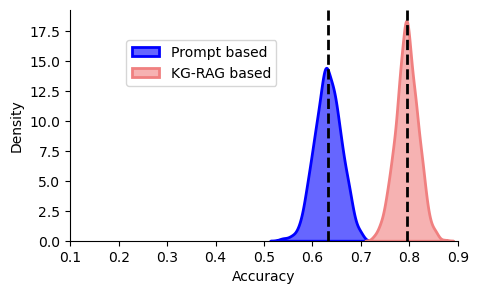

In [72]:
plot_hist_mcq(gpt_35_prompt_correct_frac_list_mcq, gpt_35_rag_correct_frac_list_mcq, figure_folder_name="GPT/entity_recognition_based", fig_name_prefix="gpt_35_turbo")


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/1489141184.py:169: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/1489141184.py:170: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


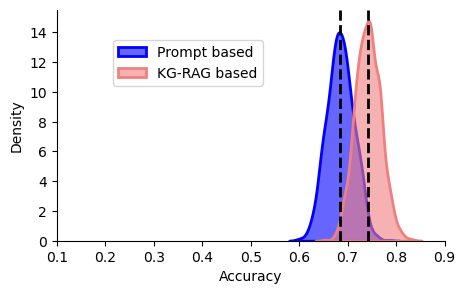

In [73]:
plot_hist_mcq(gpt_4_prompt_correct_frac_list_mcq, gpt_4_rag_correct_frac_list_mcq, figure_folder_name="GPT/entity_recognition_based", fig_name_prefix="gpt_4")


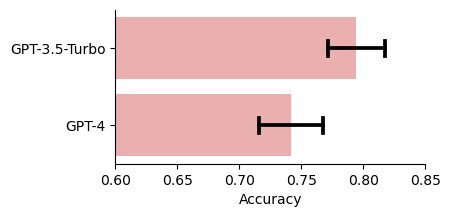

In [79]:
MODEL_LIST = ["GPT-3.5-Turbo", "GPT-4"]

list1 = gpt_35_rag_correct_frac_list_mcq
list2 = gpt_4_rag_correct_frac_list_mcq
data_to_plot = pd.DataFrame({
    'Model': [MODEL_LIST[0]] * len(list1) + [MODEL_LIST[1]] * len(list2),
    'Accuracy': list1 + list2
})

fig = plt.figure(figsize=(4, 2))
# bar_plot = sns.barplot(x='Model', y='Performance', data=data_to_plot, capsize=0.2, errcolor='k', errorbar=("ci", 95))
bar_plot = sns.barplot(x='Accuracy', y='Model', color="lightcoral", data=data_to_plot, capsize=0.2, errcolor='black', errorbar=("sd"), alpha=0.7)
# bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)
sns.despine(top=True, right=True)
plt.xlabel('Accuracy')
plt.ylabel('')
plt.xlim(0.6, 0.85)

plt.show()

figure_folder_name = "GPT/entity_recognition_based"
fig_filename = "../../../data/analysis_results/figures/{}/gpt_comparison_mcq_data.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [58]:
np.mean(gpt_35_rag_correct_frac_list_binary)

0.9241199999999999

/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/4029413896.py:136: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/4029413896.py:137: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


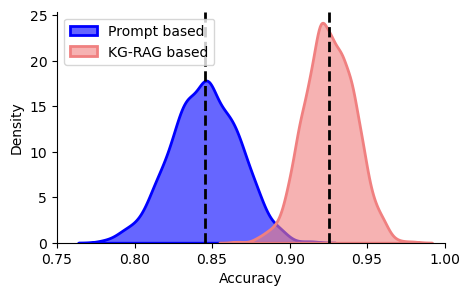

In [109]:
plot_hist_binary(gpt_35_prompt_correct_frac_list_binary, gpt_35_rag_correct_frac_list_binary, figure_folder_name="GPT/entity_recognition_based", fig_name_prefix="gpt_35_turbo")


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/4029413896.py:136: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_77895/4029413896.py:137: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


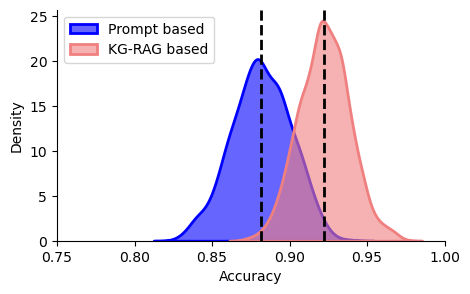

In [89]:
plot_hist_binary(gpt_4_prompt_correct_frac_list_binary, gpt_4_rag_correct_frac_list_binary, figure_folder_name="GPT/entity_recognition_based", fig_name_prefix="gpt_4")


In [110]:
np.mean(gpt_35_prompt_correct_frac_list_binary)

0.8451733333333333